In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**1. Remove dodgy images**

In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt 

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**2. Load Data**


In [9]:
import numpy as np
from matplotlib import pyplot as plt

**Charger les images depuis un dossier en tant que dataset TensorFlow**


In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


**Convertir le dataset en un itérateur Python**

In [16]:
data_iterator = data.as_numpy_iterator()

**Récupérer le premier batch d'images et de labels**

In [17]:
batch = data_iterator.next()

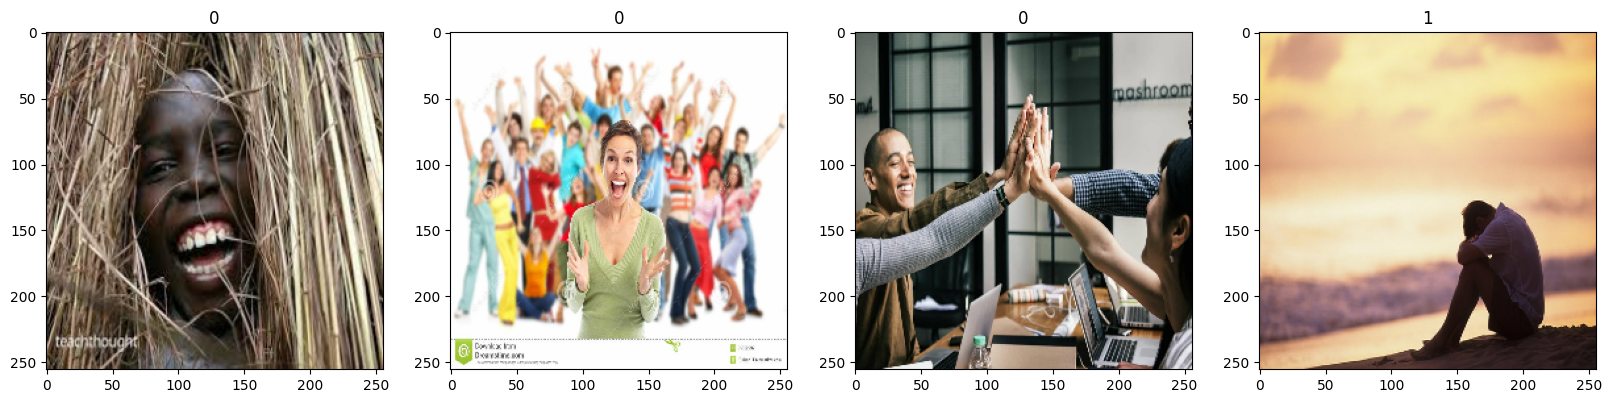

In [20]:
# Créer une figure avec 4 sous-graphes (colonnes) et une taille de figure de 20x20
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Parcourir les 4 premières images du batch (images du lot) et les afficher
for idx, img in enumerate(batch[0][:4]):
    # Afficher l'image actuelle en la convertissant en entier (pour un affichage correct)
    ax[idx].imshow(img.astype(int))

    # Définir le titre de chaque image avec le label correspondant du batch
    ax[idx].title.set_text(batch[1][idx])

**3. Scale Data**
